In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import random

from winetasting import WineTasting, load_example_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
answer_df, red_herring_wines, guess_df = load_example_data()
answer_df.head()

wine_id         country        brand           wine_type  price
0       28       argentina       wapisa              malbec     15
1       54           italy     kirkland        pinot_grigio      5
2       86           spain  carrasvinas             verdejo      8
3       30           italy     kirkland            prosecco      8
4       92  usa_california      burgess  cabernet_sauvignon     43

In [4]:
red_herring_wines

['zinfandel', 'moscato', 'grenache', 'pinot_noir', 'sauvignon_blanc']

In [5]:
guess_df.head()

name  wine_id          guess_type  guess_price
0  Chelsey Smith       28  cabernet_sauvignon           15
1  Chelsey Smith       54        pinot_grigio           10
2  Chelsey Smith       86     sauvignon_blanc           30
3  Chelsey Smith       49              malbec           20
4  Chelsey Smith       13            riesling           13

In [6]:
wine_tasting = WineTasting(answer_df=answer_df, red_herring_wines=red_herring_wines)

In [7]:
wine_tasting.generate_tasting_format()

Guessable wines list (15 total):
bordeaux
cabernet_sauvignon
champagne
grenache
malbec
moscato
pinot_grigio
pinot_noir
prosecco
red_blend
riesling
sauvignon_blanc
syrah
verdejo
zinfandel

The order of tasting wines is:
92
54
18
88
28
49
13
86
96
65
30
11


In [11]:
# overriding order
wine_tasting.tasting_df = pd.DataFrame({'wine_id': [28, 54, 86, 49, 13, 18, 11, 88, 65, 92, 96, 30]})
wine_tasting.tasting_df['tasting_order'] = [x for x in range(wine_tasting.tasting_df.shape[0])]

# record guesses
wine_tasting.guess_df = guess_df.copy()

In [12]:
wine_tasting.get_results()

# Announcements:
- There are 12 number of wines
- The order of tasting is randomized
- We will taste in batches of 2-3 then reveal
- Please let me open each wine bottle
- There are some wine types with multiple, so just because you saw it already does not mean it won't show up again
- And technically some are not strictly speaking _wine_
- You will guess the wine type and the price
- There is a written list of the types of wine here today, plus a few red herrings
- Price per bottle is always lower than \\$50
- Whomever gets the most wine types correct wins \\$40, 2nd place is \\$20
- Whomever gets the closest average price wins \\$40, 2nd place is \\$20
- Spread the love, no repeat winners
- Ties might result in a taste-off

In [13]:
analysis_df, results_df = wine_tasting.analysis_df.copy(), wine_tasting.results_df.copy()
answer_df = wine_tasting.answer_df.copy()

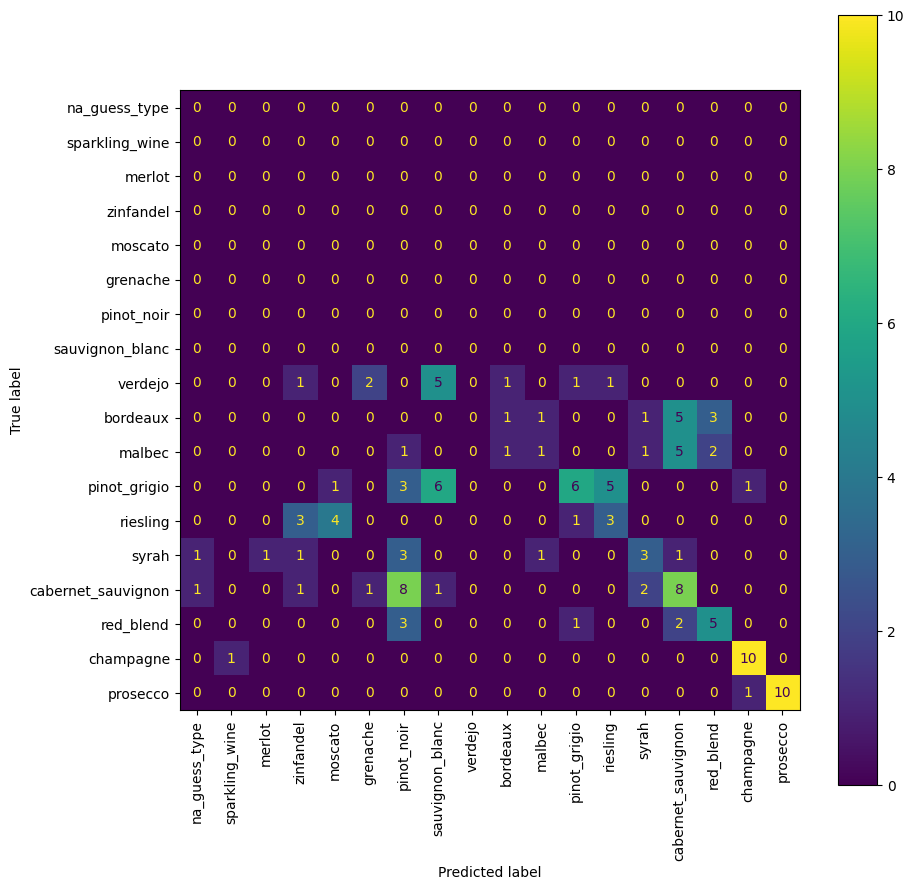

In [14]:
from winetasting.visuals import create_confusion_matrix
fig, ax = create_confusion_matrix(analysis_df, red_herring_wines)
# fig

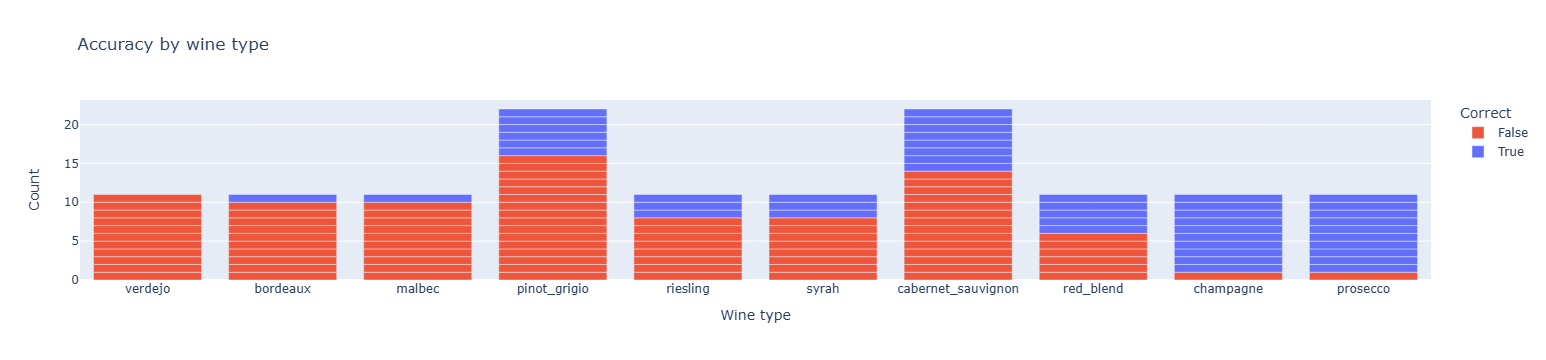

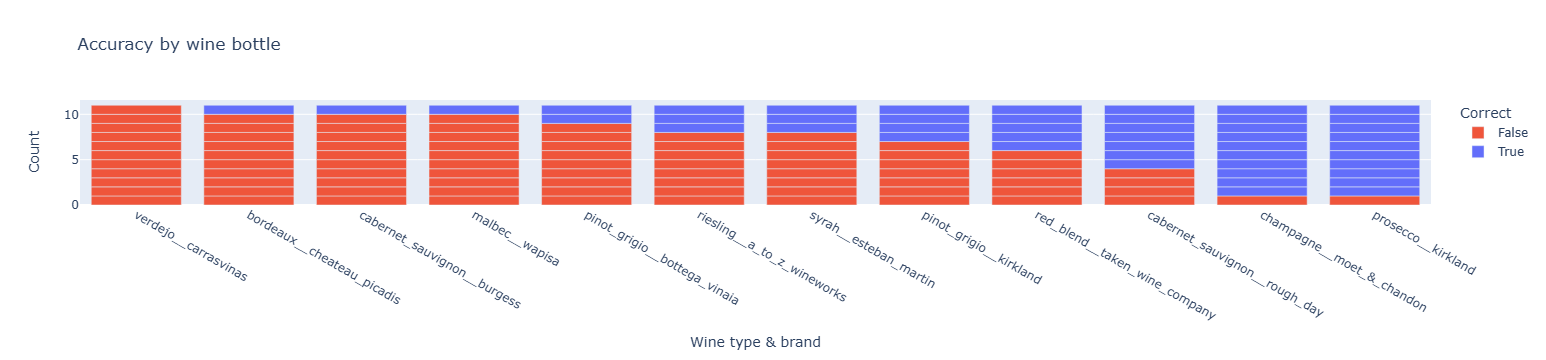

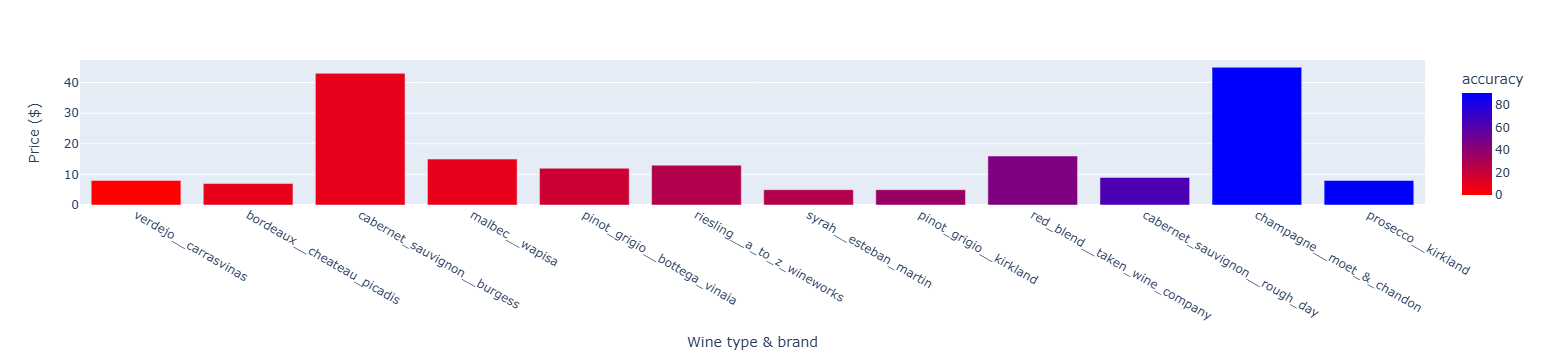

In [15]:
from winetasting.visuals import create_accuracy_visuals
create_accuracy_visuals(analysis_df)

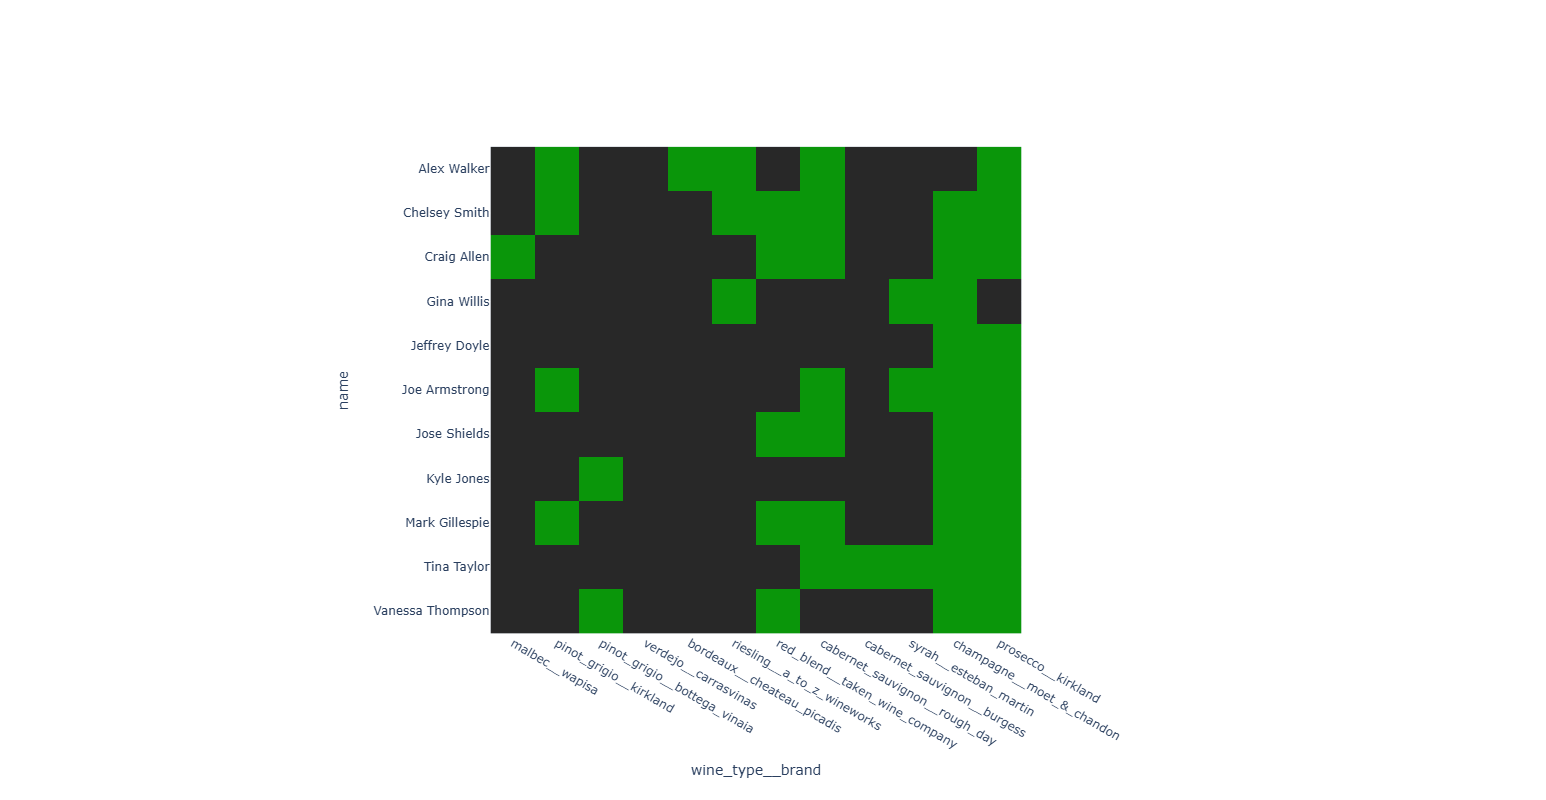

In [16]:

labels = {'name': 'Name', 'wine_type__brand': 'Wine type & brand'}

plot_df = analysis_df.copy()
plot_df['wine_type__brand'] = plot_df['wine_type'] + '__' + plot_df['brand']
plot_df = pd.pivot_table(plot_df, values='correct_type', index=['name'], columns=['wine_type__brand'])

analysis_df['wine_type__brand'] = analysis_df['wine_type'] + '__' + analysis_df['brand']
wine_type_brand_order = analysis_df['wine_type__brand'].unique().tolist()
plot_df = plot_df[wine_type_brand_order]

fig = px.imshow(plot_df, height = 800, width = 800, color_continuous_scale=['rgb(40,40,40)', 'rgb(10,150,10)'], labels=labels)
fig.update(layout_coloraxis_showscale=False)
fig.show()

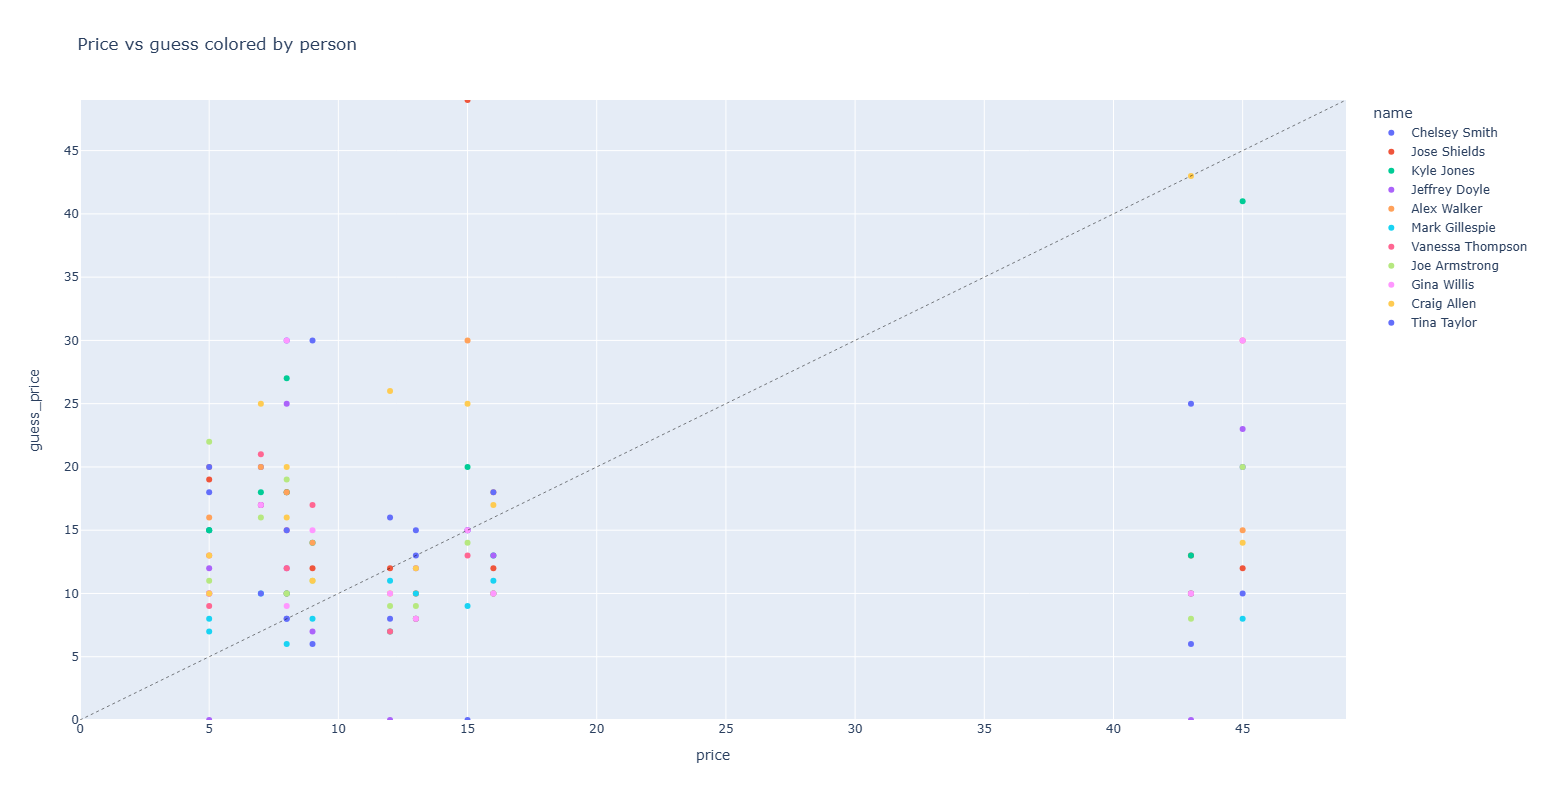

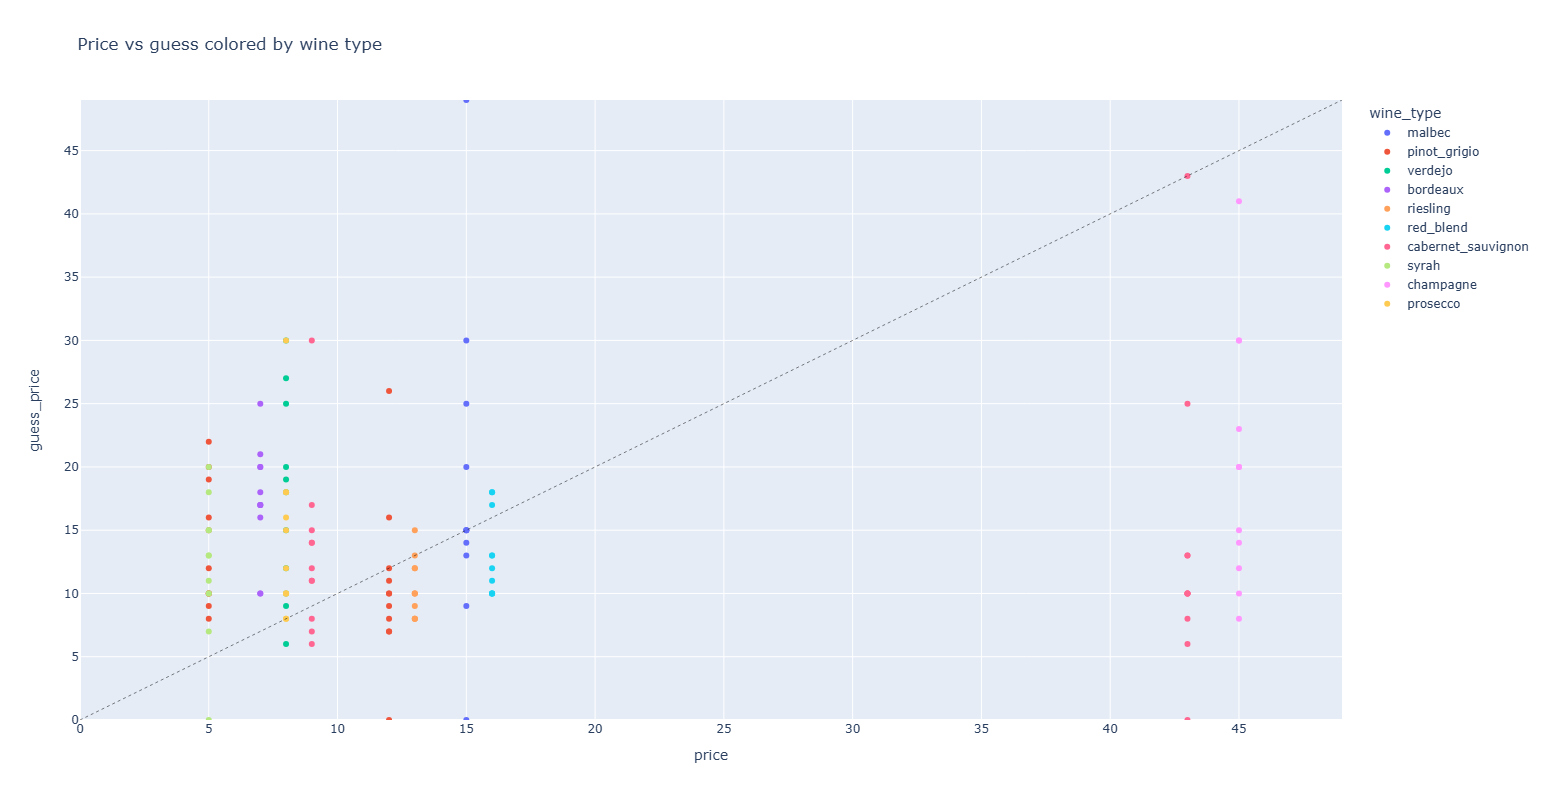

In [17]:
def make_plot(plot_df, x, y, color, title=''):
    fig=px.scatter(plot_df, x=x, y=y, color=color, width=1000, height=800, title=title, hover_data=['wine_id', 'wine_type', 'brand', 'country'])
    total_range=[0, plot_df[[x, y]].max().max()]
    fig.update_xaxes(range=total_range)
    fig.update_yaxes(range=total_range)
    fig.add_trace(go.Scatter(x=total_range, y=total_range, mode='lines', line=dict(color='black', dash='dot', width=0.5), showlegend=False))
    fig.show()

make_plot(analysis_df, 'price', 'guess_price', 'name', 'Price vs guess colored by person')
make_plot(analysis_df, 'price', 'guess_price', 'wine_type', 'Price vs guess colored by wine type')

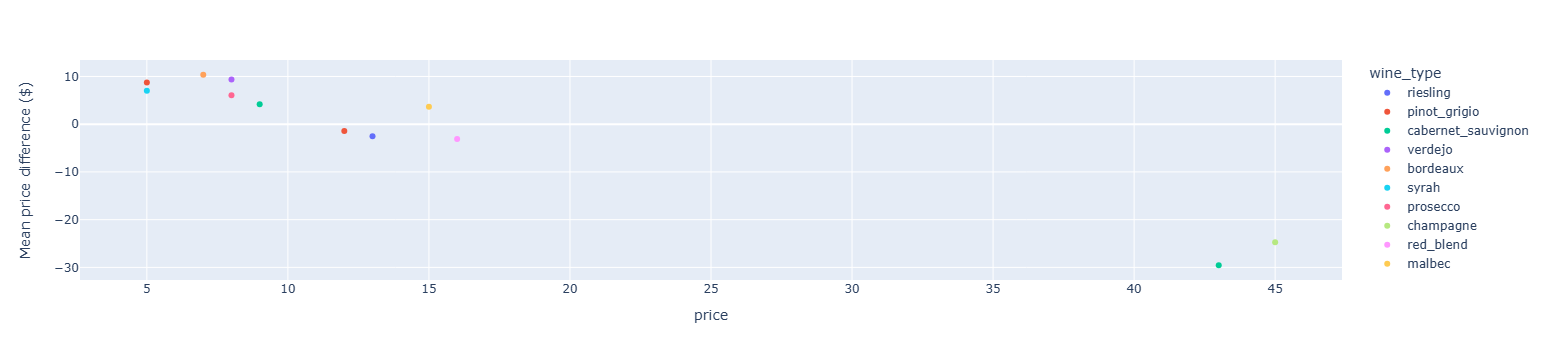

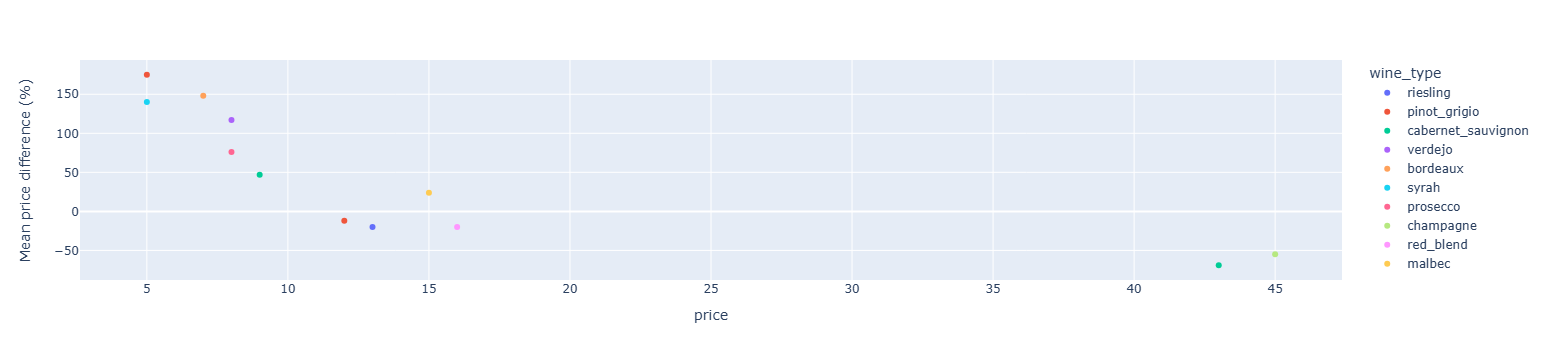

In [18]:
plot_df = analysis_df.groupby(['brand', 'wine_type', 'price'])[['price_diff', 'percent_price_diff']].mean().rename(columns={'price_diff': 'mean_price_diff', 'percent_price_diff': 'mean_percent_price_diff'})
plot_df['mean_price_diff'] = plot_df['mean_price_diff'].round(2)
plot_df['mean_percent_price_diff'] = plot_df['mean_percent_price_diff'].round(0)
plot_df = plot_df.reset_index().merge(answer_df)
plot_df['wine_type__brand'] = plot_df['wine_type'] + '__' + plot_df['brand']

px.scatter(plot_df, color='wine_type', x='price', y='mean_price_diff', hover_data=['brand'], labels={'mean_price_diff': 'Mean price difference ($)'}).show()
px.scatter(plot_df, color='wine_type', x='price', y='mean_percent_price_diff', hover_data=['brand'], labels={'mean_percent_price_diff': 'Mean price difference (%)'}).show()

In [19]:
labels

{'name': 'Name', 'wine_type__brand': 'Wine type & brand'}

# Winners

In [21]:
performance_df = analysis_df.groupby('name')['correct_type'].sum().reset_index()
performance_df = performance_df.merge(analysis_df.groupby('name')['abs_price_diff'].mean().rename('price_error').round(2).reset_index())

In [22]:
performance_df.sort_values('correct_type', ascending=False)

name  correct_type  price_error
1      Chelsey Smith             6        10.42
0        Alex Walker             5        11.75
2        Craig Allen             5         9.17
5      Joe Armstrong             5        10.08
8     Mark Gillespie             5         8.17
9        Tina Taylor             5        11.25
6       Jose Shields             4        12.33
10  Vanessa Thompson             4         9.25
3        Gina Willis             3         9.17
7         Kyle Jones             3         9.75
4      Jeffrey Doyle             2         10.5

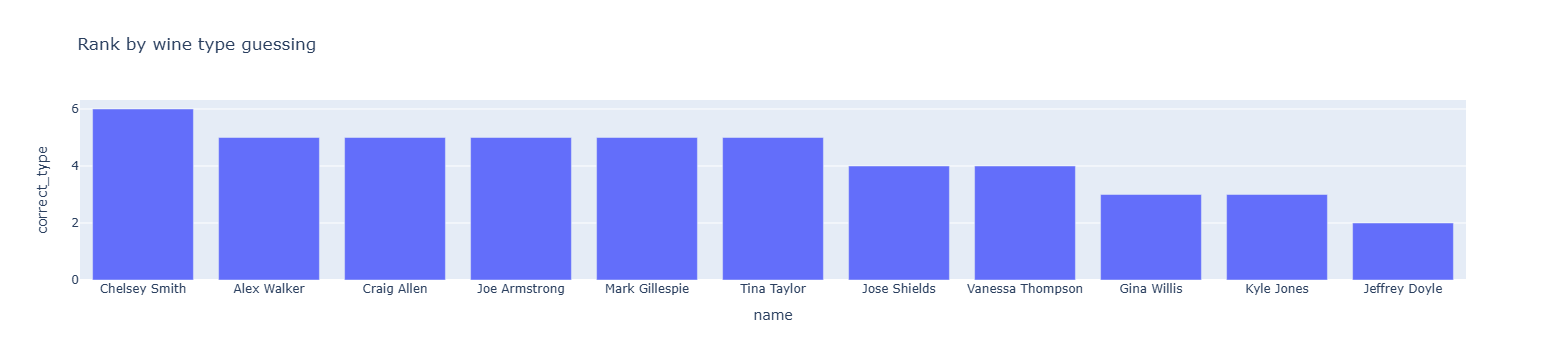

In [23]:
px.bar(performance_df.sort_values('correct_type', ascending=False), x='name', y='correct_type', title='Rank by wine type guessing')

In [24]:
performance_df.sort_values('price_error')

name  correct_type  price_error
8     Mark Gillespie             5         8.17
2        Craig Allen             5         9.17
3        Gina Willis             3         9.17
10  Vanessa Thompson             4         9.25
7         Kyle Jones             3         9.75
5      Joe Armstrong             5        10.08
1      Chelsey Smith             6        10.42
4      Jeffrey Doyle             2         10.5
9        Tina Taylor             5        11.25
0        Alex Walker             5        11.75
6       Jose Shields             4        12.33

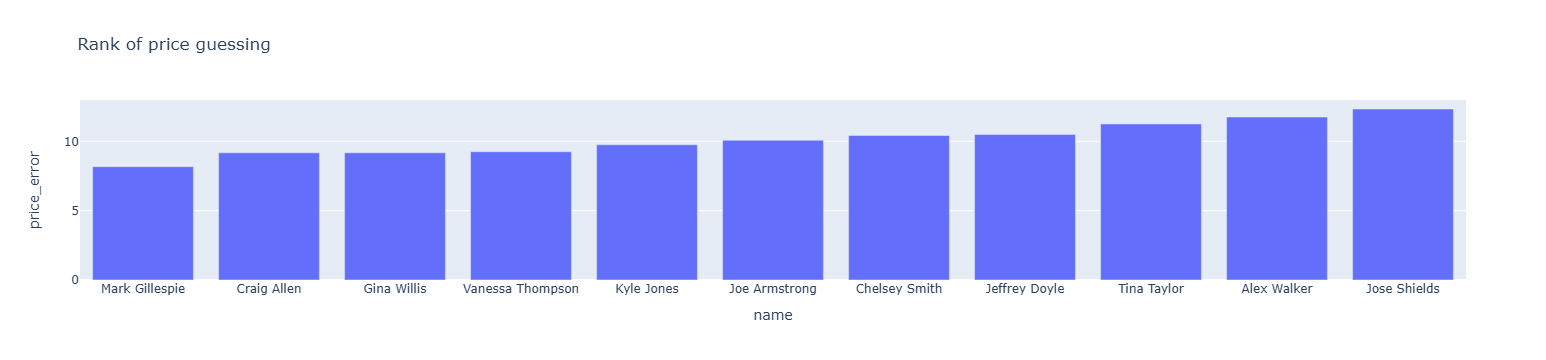

In [27]:
px.bar(performance_df.sort_values('price_error', ascending=True), x='name', y='price_error', title='Rank of price guessing')

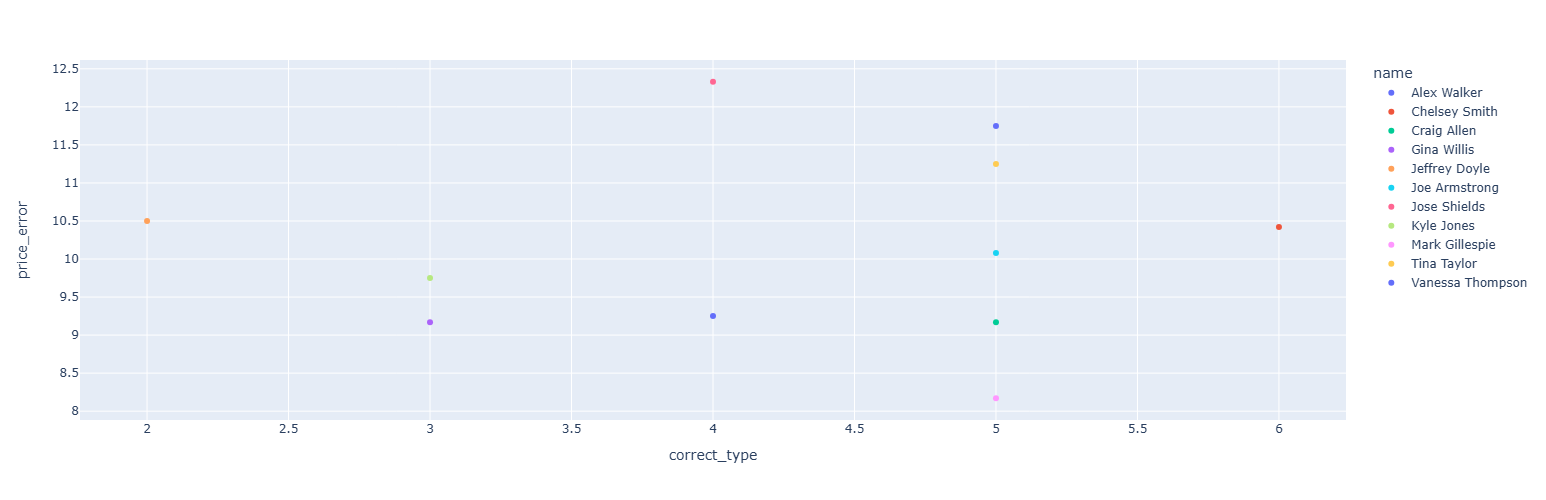

In [28]:
px.scatter(performance_df, x='correct_type', y='price_error', height=500, width=700, color='name')

# stats

In [32]:
wine_tasting.red_herring_wines

['zinfandel', 'moscato', 'grenache', 'pinot_noir', 'sauvignon_blanc']

In [33]:
wine_tasting.answer_df['wine_type'].unique().tolist()

['malbec',
 'pinot_grigio',
 'verdejo',
 'prosecco',
 'cabernet_sauvignon',
 'bordeaux',
 'riesling',
 'red_blend',
 'syrah',
 'champagne']

In [36]:
from scipy.stats import fisher_exact
df = analysis_df.copy()
df['red'] = df['wine_type'].isin(['red_blend', 'syrah', 'cabernet_sauvignon', 'grenache', 'pinot_noir', 'bordeaux', 'malbec'])
table = np.array([
    [df.query('red==True')['correct_type'].sum(), (~df.query('red==True')['correct_type']).sum()],
    [df.query('red==False')['correct_type'].sum(), (~df.query('red==False')['correct_type']).sum()]
])
                  
res = fisher_exact(table, alternative='two-sided')
res.pvalue

0.06856205143881657

In [38]:
all_wines = wine_tasting.red_herring_wines + wine_tasting.answer_df['wine_type'].unique().tolist()

In [49]:
from scipy.stats import binom
binom.stats(3, 1/15)

(1.2, 0.18666666666666668)

In [62]:
analysis_df.groupby('name')['correct_type'].sum()

name
Alex Walker         5
Chelsey Smith       6
Craig Allen         5
Gina Willis         3
Jeffrey Doyle       2
Joe Armstrong       5
Jose Shields        4
Kyle Jones          3
Mark Gillespie      5
Tina Taylor         5
Vanessa Thompson    4
Name: correct_type, dtype: Int64

In [109]:
def binomial(guesses, probability_of_correct):
    r_values = list(range(guesses + 1)) 
    probabilities = [binom.pmf(r, guesses, probability_of_correct) for r in r_values]
    return [sum(probabilities[n:]) for n in range(len(probabilities))]

p=binomial(answer_df.shape[0], 1/len(all_wines))
p

[0.9999999999999999,
 0.5630403655547606,
 0.18850353603026987,
 0.04136406728850561,
 0.006330860445228428,
 0.0007005236311303047,
 5.705656666194747e-05,
 3.4343112895843575e-06,
 1.513160627049851e-07,
 4.7537757907274745e-09,
 1.010047775764384e-10,
 1.3025415803447612e-12,
 7.707346629258938e-15]

In [115]:
merge_df = analysis_df.query('wine_type not in ("prosecco", "champagne")').groupby('name')['correct_type'].sum().rename('wine_only_correct').reset_index()

In [118]:
p=binomial(answer_df.shape[0], 1/len(all_wines))
chances_df = analysis_df.groupby('name')['correct_type'].sum().reset_index()
chances_df['all_guesses'] = chances_df['correct_type'].apply(lambda x: p[x])

p=binomial(10, 1/13)
merge_df = analysis_df.query('wine_type not in ("prosecco", "champagne")').groupby('name')['correct_type'].sum().rename('wine_only_correct').reset_index()
chances_df = chances_df.merge(merge_df)
chances_df['wine_only'] = chances_df['wine_only_correct'].apply(lambda x: p[x])
chances_df

name  correct_type  all_guesses  wine_only_correct  wine_only
0        Alex Walker             5     0.000701                  4   0.005037
1      Chelsey Smith             6     0.000057                  4   0.005037
2        Craig Allen             5     0.000701                  3   0.036227
3        Gina Willis             3     0.041364                  2   0.176582
4      Jeffrey Doyle             2     0.188504                  0   1.000000
5      Joe Armstrong             5     0.000701                  3   0.036227
6       Jose Shields             4     0.006331                  2   0.176582
7         Kyle Jones             3     0.041364                  1   0.550863
8     Mark Gillespie             5     0.000701                  3   0.036227
9        Tina Taylor             5     0.000701                  3   0.036227
10  Vanessa Thompson             4     0.006331                  2   0.176582

In [179]:
analysis_df['wine_id'].nunique()

12

In [136]:
from scipy.stats import multinomial
multinomial.pmf([1, 1], n=2, p=[0.5, 0.5])

0.5

In [148]:
from scipy.stats import multinomial
rv = multinomial(5, [0.5, 0.25, 0.25])
rv.pmf([3, 1, 1])

0.15624999999999994

In [254]:
def multinomial_helper(guessers=5, bottles=3):
    
    binomial_dist = [binom.pmf(r, bottles, 1/bottles) for r in range(bottles+1)]
    possible_guess_counts = [x for x in range(guessers+1)]
    possible_guess_dist = [seq for seq in itertools.product(possible_guess_counts, repeat=bottles+1) if sum(seq) == guessers]

    total_correct = []
    for x in possible_guess_dist:
        new=0
        for num_correct, num_guessers in enumerate(x):
            new += num_correct*num_guessers
        total_correct.append(new)
        
    guess_prob_df = pd.DataFrame({'possible_guess_dist': possible_guess_dist, 'total_correct': total_correct})
    # import pdb; pdb.set_trace()
    p = [multinomial.pmf(row['possible_guess_dist'], n=guessers, p=binomial_dist) for i, row in guess_prob_df.iterrows()]
    guess_prob_df['prob'] = p

    at_least_correct_prob_df = guess_prob_df.groupby('total_correct')['prob'].sum()
    at_least_correct_prob_df = at_least_correct_prob_df.iloc[::-1].cumsum().iloc[::-1]
    
    return at_least_correct_prob_df, guess_prob_df, binomial_dist

at_least_correct_prob_df, guess_prob_df, binomial_dist = multinomial_helper()
print(at_least_correct_prob_df)
guess_prob_df

total_correct
0     1.000000e+00
1     9.977163e-01
2     9.805889e-01
3     9.206429e-01
4     7.907598e-01
5     5.959352e-01
6     3.816282e-01
7     2.030389e-01
8     8.823160e-02
9     3.082792e-02
10    8.504271e-03
11    1.807176e-03
12    2.851088e-04
13    3.143097e-05
14    2.160443e-06
15    6.969172e-08
Name: prob, dtype: float64


possible_guess_dist  total_correct          prob
0         (0, 0, 0, 5)             15  6.969172e-08
1         (0, 0, 1, 4)             14  2.090752e-06
2         (0, 0, 2, 3)             13  2.508902e-05
3         (0, 0, 3, 2)             12  1.505341e-04
4         (0, 0, 4, 1)             11  4.516023e-04
5         (0, 0, 5, 0)             10  5.419228e-04
6         (0, 1, 0, 4)             13  4.181503e-06
7         (0, 1, 1, 3)             12  1.003561e-04
8         (0, 1, 2, 2)             11  9.032047e-04
9         (0, 1, 3, 1)             10  3.612819e-03
10        (0, 1, 4, 0)              9  5.419228e-03
11        (0, 2, 0, 3)             11  1.003561e-04
12        (0, 2, 1, 2)             10  1.806409e-03
13        (0, 2, 2, 1)              9  1.083846e-02
14        (0, 2, 3, 0)              8  2.167691e-02
15        (0, 3, 0, 2)              9  1.204273e-03
16        (0, 3, 1, 1)              8  1.445127e-02
17        (0, 3, 2, 0)              7  4.335382e-02
18        (0, 4, 0, 1)              7  7.225637e-03
19        (0, 4, 1, 0)              6  4.335382e-02
20        (0, 5, 0, 0)              5  1.734153e-02
21        (1, 0, 0, 4)             12  2.787669e-06
22        (1, 0, 1, 3)             11  6.690405e-05
23        (1, 0, 2, 2)             10  6.021365e-04
24        (1, 0, 3, 1)              9  2.408546e-03
25        (1, 0, 4, 0)              8  3.612819e-03
26        (1, 1, 0, 3)             10  1.338081e-04
27        (1, 1, 1, 2)              9  2.408546e-03
28        (1, 1, 2, 1)              8  1.445127e-02
29        (1, 1, 3, 0)              7  2.890255e-02
30        (1, 2, 0, 2)              8  2.408546e-03
31        (1, 2, 1, 1)              7  2.890255e-02
32        (1, 2, 2, 0)              6  8.670765e-02
33        (1, 3, 0, 1)              6  1.926837e-02
34        (1, 3, 1, 0)              5  1.156102e-01
35        (1, 4, 0, 0)              4  5.780510e-02
36        (2, 0, 0, 3)              9  4.460270e-05
37        (2, 0, 1, 2)              8  8.028486e-04
38        (2, 0, 2, 1)              7  4.817092e-03
39        (2, 0, 3, 0)              6  9.634183e-03
40        (2, 1, 0, 2)              7  1.605697e-03
41        (2, 1, 1, 1)              6  1.926837e-02
42        (2, 1, 2, 0)              5  5.780510e-02
43        (2, 2, 0, 1)              5  1.926837e-02
44        (2, 2, 1, 0)              4  1.156102e-01
45        (2, 3, 0, 0)              3  7.707347e-02
46        (3, 0, 0, 2)              6  3.568216e-04
47        (3, 0, 1, 1)              5  4.281859e-03
48        (3, 0, 2, 0)              4  1.284558e-02
49        (3, 1, 0, 1)              4  8.563718e-03
50        (3, 1, 1, 0)              3  5.138231e-02
51        (3, 2, 0, 0)              2  5.138231e-02
52        (4, 0, 0, 1)              3  1.427286e-03
53        (4, 0, 1, 0)              2  8.563718e-03
54        (4, 1, 0, 0)              1  1.712744e-02
55        (5, 0, 0, 0)              0  2.283658e-03

In [198]:
df['prob'].sum()

0.0

In [37]:
random_df = analysis_df.copy()
random_df['wine_type']

name  wine_id          guess_type  guess_price    country  \
0       Chelsey Smith       28  cabernet_sauvignon           15  argentina   
1        Jose Shields       28  cabernet_sauvignon           49  argentina   
2          Kyle Jones       28           red_blend           20  argentina   
3       Jeffrey Doyle       28           red_blend           15  argentina   
4         Alex Walker       28               syrah           30  argentina   
..                ...      ...                 ...          ...        ...   
127    Mark Gillespie       30            prosecco           10      italy   
128  Vanessa Thompson       30            prosecco           15      italy   
129     Joe Armstrong       30            prosecco           10      italy   
130       Gina Willis       30           champagne           30      italy   
131       Tina Taylor       30            prosecco            8      italy   

        brand wine_type  price  tasting_order  correct_type  price_diff  \
0      wapisa    malbec     15              0         False           0   
1      wapisa    malbec     15              0         False          34   
2      wapisa    malbec     15              0         False           5   
3      wapisa    malbec     15              0         False           0   
4      wapisa    malbec     15              0         False          15   
..        ...       ...    ...            ...           ...         ...   
127  kirkland  prosecco      8             11          True           2   
128  kirkland  prosecco      8             11          True           7   
129  kirkland  prosecco      8             11          True           2   
130  kirkland  prosecco      8             11         False          22   
131  kirkland  prosecco      8             11          True           0   

     abs_price_diff  type_accuracy  bottle_accuracy  percent_price_diff  \
0                 0              9                9                 0.0   
1                34              9                9               227.0   
2                 5              9                9                33.0   
3                 0              9                9                 0.0   
4                15              9                9               100.0   
..              ...            ...              ...                 ...   
127               2             90               90                25.0   
128               7             90               90                88.0   
129               2             90               90                25.0   
130              22             90               90               275.0   
131               0             90               90                 0.0   

       wine_type__brand  
0        malbec__wapisa  
1        malbec__wapisa  
2        malbec__wapisa  
3        malbec__wapisa  
4        malbec__wapisa  
..                  ...  
127  prosecco__kirkland  
128  prosecco__kirkland  
129  prosecco__kirkland  
130  prosecco__kirkland  
131  prosecco__kirkland  

[132 rows x 16 columns]